In [11]:
# Import packages

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


## Introduction

In this analysis, we aim to address these inquiries: What are the key factors influencing reservation prices when seeking accommodation while traveling to a different city or country? Does the time of year impact prices, and which periods are considered the busiest for visiting specific cities? Moreover, we seek to provide insights on how to economize when making reservations.

The Airbnb reservation price is influenced by various costs, including those determined by the host and Airbnb itself. Host-determined costs include the nightly price, cleaning fee, and extra guest fees. Additionally, Airbnb charges a service fee. Other potential costs may include currency exchange fees, VAT, and local taxes.

For our analysis, we will focus on the factors that impact the nightly price, which is determined by the host. Airbnb already utilizes an algorithm to suggest prices to hosts. However, we will consider the following elements that contribute to the pricing of a listing:

1. Time of Year: The timing of the reservation can affect the price.
2. Amenities: The amenities provided, such as Wi-Fi and TV, can have a significant influence on the price.
3. Neighbourhood Information: Describing the listing location using neighbourhood information, rather than exact coordinates, is preferable. This is because even nearby locations can have substantial price differences if they belong to different neighbourhoods or are situated on different sides of a river.

## Method

To analyze the factors influencing reservation prices in the Seattle dataset, we follow these steps:

1. First Look at the Data:
   - Identify the available information in the dataset, such as columns and variables.
   - Determine if there is any missing information and assess the extent of missing data.
   - Discover general facts about the dataset, such as the time period covered and the total number of listings.


2. Initial Data Preparation:
   - Remove irrelevant information that is not essential for the analysis.
   - Reformat the data, ensuring consistency and compatibility across variables.
   - Address missing values by either imputing them or considering their impact on the analysis.


3. High-Level Analysis:
   - Conduct an exploratory analysis to identify high-level trends and correlations in the data.
   - Explore relationships between variables and reservation prices.
   - Identify any notable patterns or outliers that may influence the analysis.



By following these steps, we can gain a comprehensive understanding of the factors that affect reservation prices in the Seattle dataset and draw meaningful conclusions from our analysis.

## First Look at the Data

AirBnB has supplied us with three datasets pertaining to Seattle:
1. listings.csv: This dataset contains a comprehensive summary of information regarding the listings in Seattle, including details about their location, host information, cleaning and guest fees, amenities, and more.
2. calendar.csv: The calendar dataset provides information on the availability dates and corresponding prices for each listing.
3. reviews.csv: Although this dataset consists of summarized review data for the listings, it will not be utilized in the subsequent analysis.

Please note that specific statistics for the listings.csv dataset are not available without access to the actual data.
Statistics for listings.csv dataset is as follows.

In [2]:
# Load data
listings_df = pd.read_csv('./Seattle/listings.csv')

# Find unique listings and hosts number
listings_number = listings_df['id'].count()
hosts_number = len(listings_df['host_id'].unique())

print('listings.csv dataset includes %d listings provided by %d hosts.' % (listings_number, hosts_number))

listings.csv dataset includes 3818 listings provided by 2751 hosts.


The 'calendar.csv' dataset contains 1393570 rows.
The first date of observation is 2016-01-04 and the last date is 2017-01-02.


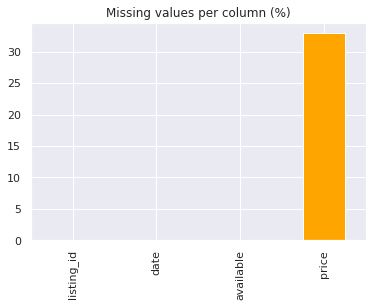

In [37]:
# Read the dataset
calendar_df = pd.read_csv('./Seattle/calendar.csv')

# Calculate the number of rows in the dataset
rows_num = calendar_df.shape[0]

# Identify the first and last date of observation
min_date = calendar_df['date'].min()
max_date = calendar_df['date'].max()

# Print the information about the dataset
print("The 'calendar.csv' dataset contains %d rows." % rows_num)
print("The first date of observation is %s and the last date is %s." % (min_date, max_date))

# Calculate missing values statistics in the calendar.csv dataset
calendar_missing_percentage = calendar_df.isnull().mean() * 100

# Create a DataFrame to store missing values percentage
calendar_missing_df = pd.DataFrame([calendar_missing_percentage])

# Plot the results
ax = calendar_missing_df.T.plot(kind='bar', legend=False, title='Missing values per column (%)',color='orange')

# Save the figure
plt.savefig('missing_values_plot.png')

Based on the diagram, we observe that the price column in the listings.csv dataset exhibits only 32% of missing values specifically for dates when the listing was unavailable. Notably, the price column is the sole attribute containing missing values, where certain listing IDs do not have any corresponding price information.

## Data Preparation

In order to obtain initial outcomes from the data, it is necessary to perform data pre-processing steps, including:

1. Merging Datasets: Merge the datasets into a single dataset using the listing identifier as a key, combining relevant information from each dataset.

2. Removing Irrelevant Columns: Eliminate columns that contain missing data and are deemed irrelevant for the analysis, as they may not contribute to the desired outcomes.

3. Converting Text to Numerical Values: Convert dates and prices from their original text format into numerical values, enabling quantitative analysis and computations.

By completing these pre-processing tasks, the data will be ready for further analysis to derive meaningful insights and outcomes.

In [43]:
# Helper functions for pre-processing

def get_month_from_date(row):
    ''' Obtain the month from a date that is represented as a string '''
    return int(row['date'].split('-')[1])

def get_year_from_date(row):
    ''' Obtain the year from a date that is represented as a string '''
    return int(row['date'].split('-')[0])

def get_host_since_year(row):
    ''' Get year from a date represented as a string '''
    try:
        host_since = int(row['host_since'].split('-')[0])
    except:
        host_since = np.nan
    return host_since

def get_val_from_list(row, column_name, value):
    ''' Populate a dummy column with specific values '''
    val = 0.0
    try:
        vals = row[column_name].replace('[', '').replace("'", '').replace("]", '').replace('"', '').replace('{', '').replace('}', '').split(',')
        if value in vals:
            val = 1.0
    except:
        val = 0.0
    return val

def split_list_into_columns(df, column_name, max_dummies_num = 10):
    ''' Separate values within columns that contain lists, such as amenities '''
    
    # Get dictionary of unique values in lists across dataset rows
    values_dict = {}

    for unique_value in df[column_name].unique(): 
        for value in unique_value.replace('[', '').replace("'", '').replace("]", '').replace('"', '').replace('{', '').replace('}', '').split(','):
            if value in values_dict:
                values_dict[value] = values_dict[value] + 1
            else:
                values_dict[value] = 0
                
    values_sorted = sorted(values_dict.items(), key=lambda kv: kv[1], reverse = True)
      
    # Split into columns
    for value in values_sorted[: max_dummies_num]:
        df[column_name + '_' + value[0]] = df.apply(lambda row: get_val_from_list(row, column_name, value[0]),axis=1)
        
    return

def get_extra_people_fee(row):
    ''' Return 1 when there is and extra fee for exatra people '''
    if row['extra_people'] == '$0.00':
        return 0.0
    else:
        return 1.0

# Main dataset cleaning function
def clean_dataset(listings_df, calendar_df):
    """
Clean and merge datasets.

Parameters:
    listings_df (pandas.DataFrame): DataFrame containing listings data.
    calendar_df (pandas.DataFrame): DataFrame containing calendar data.

Returns:
    df (pandas.DataFrame): Cleaned dataset that includes merged tables with the following transformations:
    1. Irrelevant columns are dropped.
    2. String dates are converted into numeric values.
    3. Columns containing lists are split into multiple columns (e.g., amenities).
    4. Missing values are imputed with the mean or mode.
"""
    # Merge datasets
    listings_df = listings_df.rename(index=str, columns={"id": "listing_id"})
    df = pd.merge(calendar_df, listings_df, on = 'listing_id')
    
    # Drop the irrelevant columns
    columns_to_drop = ['available', 'host_id','host_location','host_acceptance_rate','host_neighbourhood',
                   'host_total_listings_count', 'weekly_price', 'monthly_price',
                   'security_deposit', 'cleaning_fee', 'calendar_updated',
                   'listing_url','last_scraped' ,'scrape_id', 'name', 'summary', 'space', 'description',
                   'experiences_offered', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'zipcode',
                   'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
                   'xl_picture_url', 'host_url', 'host_name', 'host_about', 'host_thumbnail_url', 'host_picture_url',
                   'city', 'state', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude',
                   'is_location_exact', 'square_feet', 'has_availability', 'availability_30',
                   'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped',
                  'first_review', 'last_review', 'requires_license', 'license', 'jurisdiction_names', 'price_y',
                  'reviews_per_month']
    df = df.drop(columns = columns_to_drop)
    
    # Convert date from the calendar into month and drop the date column
    df['month'] = df.apply(lambda row: get_month_from_date(row),axis=1)
    df['year'] = df.apply(lambda row: get_year_from_date(row),axis=1)
    df = df.drop(columns = ['date'])
    
    # Remove rows where price_x == nan, because price will be used as response column
    df = df.dropna(subset=['price_x'])
    
    # Convert price to number and drop the price_x column
    df['price'] = df['price_x'].astype(str)
    df['price'] = df['price'].str.replace("[$, ]", "").astype("float")
    df = df.drop(columns = ['price_x'])
    
    # Convert host_since date into number and fill in missing values, drop the original column
    df['host_since_year'] = df.apply(lambda row: get_host_since_year(row),axis=1)
    df['host_since_year'].fillna(df['host_since_year'].mean(), inplace = True)
    df = df.drop(columns = ['host_since'])
    
    # Convert host_response_rate into number and fill in missing values, drop the original column
    df['host_response_rate_num'] = df['host_response_rate'].astype(str)
    df['host_response_rate_num'] = df['host_response_rate_num'].str.replace("%", "").astype("float")
    df['host_response_rate_num'].fillna(df['host_response_rate_num'].mean(), inplace = True)
    
    df['host_response_rate_buckets'] = pd.qcut(df['host_response_rate_num'], 5, labels=False, duplicates = 'drop')
    
    df = df.drop(columns = ['host_response_rate', 'host_response_rate_num'])
    
    # Fill missing values with mean value for host_listings_count
    df['host_listings_count'].fillna(df['host_listings_count'].mean(), inplace = True)
    
    # Split host_verifications into dummy columns and drop the original column
    split_list_into_columns(df, 'host_verifications')
    df = df.drop(columns = ['host_verifications'])
    
    # Fill in missing values for bathrooms, bedrooms and beds with mode
    df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].mode()[0])
    df['bedrooms'] = df['bedrooms'].fillna(df['bedrooms'].mode()[0])
    df['beds'] = df['beds'].fillna(df['beds'].mode()[0])
    
    # Split amenities into dummy columns and drop the original column
    split_list_into_columns(df, 'amenities')
    df = df.drop(columns = ['amenities'])
    
    # Turn extra people fee into binary column (1 - if fee for extra people is charged, 0 - otherwise)
    df['extra_people_fee'] = df.apply(lambda row: get_extra_people_fee(row),axis=1)
    df = df.drop(columns = ['extra_people'])
    
    # Fill missing values for review scores columns
    review_scores_columns = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                         'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                        'review_scores_value']
    for column in review_scores_columns:
        df[column].fillna(df[column].mean(), inplace = True)
    
    return df

In [44]:
# Apply functions above to clean dataset
df = clean_dataset(listings_df, calendar_df)

<ipython-input-43-d3e60c91a8e1>:103: FutureWarning: The default value of regex will change from True to False in a future version.
  df['price'] = df['price'].str.replace("[$, ]", "").astype("float")


## Analysis

Now when we have clean data, we can look closer and try to find answers to our questions.

### 1- What is the distribution of the listing prices?

To begin our analysis, let's start with a broad examination of the price data. This initial overview will provide us with a high-level understanding of the prices in the dataset.

Minimum price per listing is $10.0.
Maximum price per listing is $1650.0.
Average price per listing is $137.94485855103355.


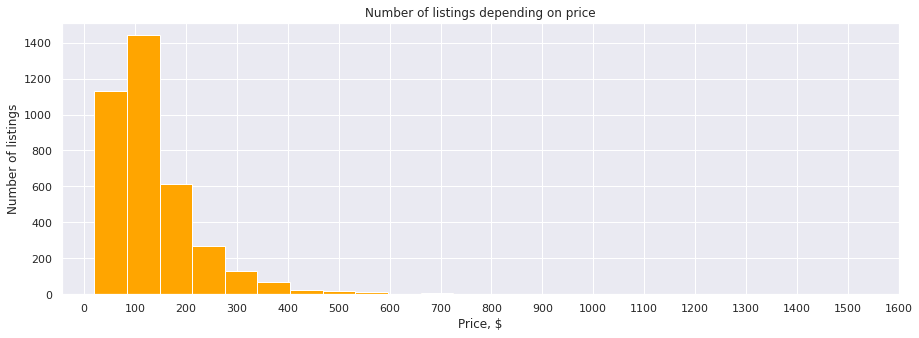

In [45]:
# Calculate the minimum, maximum, and average price for each listing
min_price = df['price'].min()
max_price = df['price'].max()
mean_price = df['price'].mean()

# Print the results
print(f"Minimum price per listing is ${min_price}.")
print(f"Maximum price per listing is ${max_price}.")
print(f"Average price per listing is ${mean_price}.")

# Calculate the average price for each listing
mean_price_for_listing = df.groupby('listing_id')['price'].mean()

# Set the plot size
plt.figure(figsize=(15, 5))

# Plot the distribution of prices
plt.hist(mean_price_for_listing, bins=20, color='orange')
plt.xticks(np.arange(0, 1700, step=100))
plt.ylabel('Number of listings')
plt.xlabel('Price, $')
plt.title('Number of listings depending on price')

# Save the plot as an image
plt.savefig('Price_distribution.png')

# Display the plot
plt.show()


Upon analyzing the distribution of average listing prices, we observe that the majority of listings are concentrated within the range of 50 to 150 USD. However, for prices exceeding 200 USD, there is a significant decline, indicating potential affordability issues for guests. It is noteworthy that the highest number of listings falls within the expected range of 50 to 150 USD.

### 2- What is the busiest time to visit Seattle?

To determine the busiest time to visit Seattle, we can consider the following factors:

1. Number of Listings: We need to examine how the number of listings varies throughout the year. This will help identify periods with higher listing availability, indicating potentially busier times.

2. Price Fluctuations: Analyzing how prices change depending on the time of year is crucial. Higher prices during specific periods suggest increased demand, indicating popular times to visit.

By assessing both the fluctuation in the number of listings and price trends throughout the year, we can gain insights into the busiest time to visit Seattle.

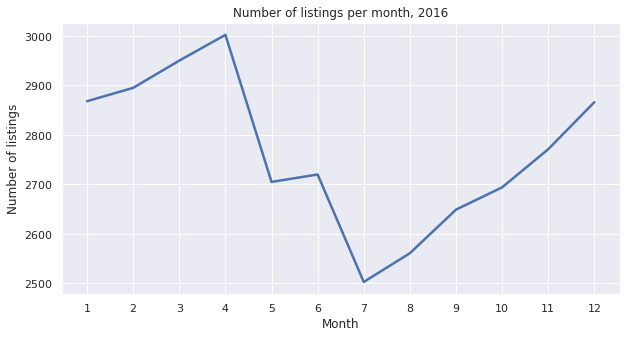

In [34]:
# Calculate the total number of listings for each month in 2016
number_of_listings_by_month = df[df['year'] == 2016].groupby('month')['listing_id'].nunique()

# Set the plot size and line width
plt.figure(figsize=(10, 5))

# Plot the number of listings per month
plt.plot(number_of_listings_by_month, linewidth=2.5)
plt.xticks(np.arange(1, 13, step=1))
plt.ylabel('Number of listings')
plt.xlabel('Month')
plt.title('Number of listings per month, 2016')

# Save the plot as an image
plt.savefig('number_of_available_listings.png')

# Display the plot
plt.show()



Based on the diagram depicting the number of listings by month, several observations can be made:

1. Lowest Availability in Summer: The number of available listings for reservation appears to be lowest during the summer months. This suggests a potential decrease in supply during this period.

2. Spike in Listings from January to April: There is a notable spike in the number of listings from January to April. This increase aligns with the expectation of a potential price decline during this timeframe.

3. Decrease in Listings during Warm Season: Starting from the warm season, there is a considerable drop in the number of listings, which could be attributed to a corresponding increase in prices.

4. Increased Listings in Summer: However, from July onwards, there is a renewed increase in the number of listings, possibly due to a rise in tourism during the summer season.

5. Continued Increase until Christmas Season: This upward trend in listings persists until the Christmas season, potentially driven by the decreased prices of listings during this time.

By analyzing the fluctuations in the number of listings and their corresponding pricing patterns, we can discern the seasonal dynamics and potential factors influencing the availability and prices in Seattle throughout the year.

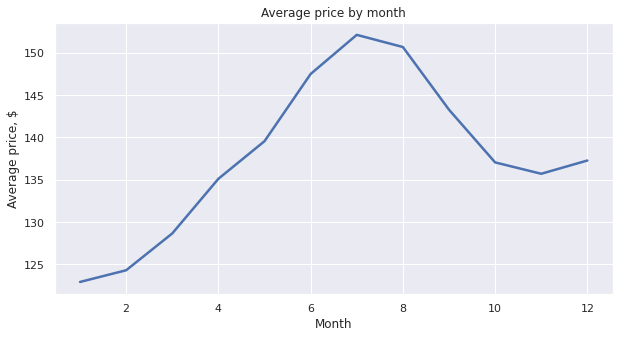

In [33]:
# Calculate the average price by month
average_price_by_month = df.groupby('month')['price'].mean()

# Set the plot size and line width
plt.figure(figsize=(10, 5))

# Plot the average price
plt.plot(average_price_by_month, linewidth=2.5)
plt.ylabel('Average price, $')
plt.xlabel('Month')
plt.title('Average price by month')

# Save the plot as an image
plt.savefig('average_price_by_month.png')

# Display the plot
plt.show()


Based on the provided diagram, it is evident that listing prices experience a significant increase during the summer, likely due to a decrease in the availability of listings for reservation. Additionally, there is a noticeable price increase in December. These findings suggest that the busiest times to visit Seattle are during the summer and winter holidays. 

Furthermore, the diagram reveals a negative correlation between listing numbers and prices, which aligns with expectations. As prices rise, the number of available listings tends to decrease, and vice versa.

By understanding the seasonal price fluctuations and their impact on listing availability, we can better plan and anticipate the busiest periods for visiting Seattle.

### 3- What is the distribution of listing prices based on choice of neighborhood?

As previously mentioned, the neighborhood can have a significant influence on listing prices. Therefore, let's examine how listing prices vary depending on different neighborhoods.

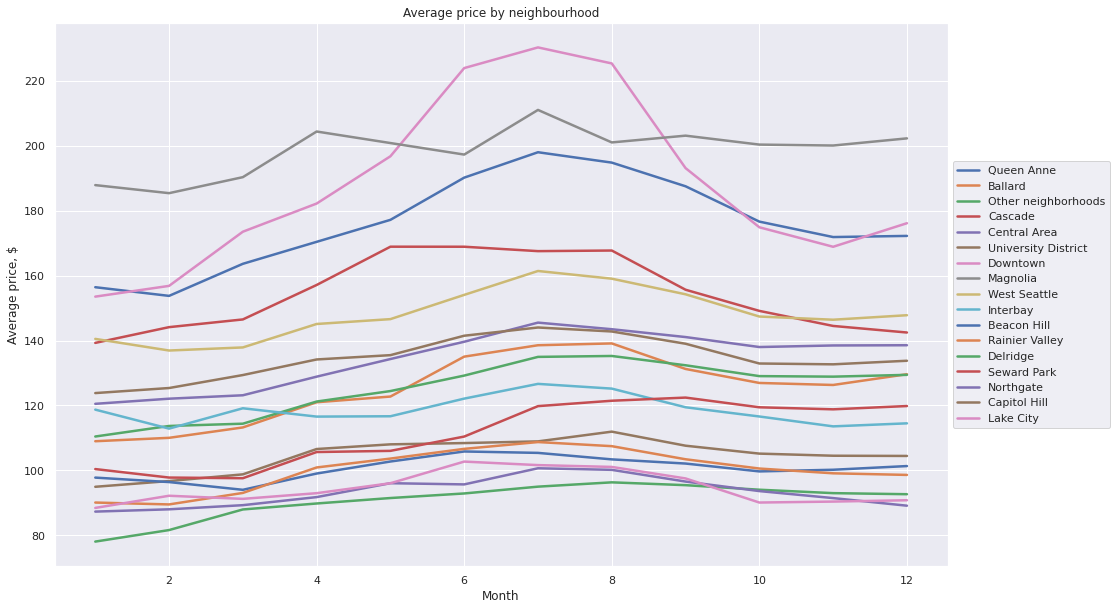

In [23]:
# Get unique neighbourhoods
neighbourhoods = df['neighbourhood_group_cleansed'].unique()

# Group data by month and neighbourhood and calculate mean price
price_by_month_neighbourhood = df.groupby(['month', 'neighbourhood_group_cleansed']).mean().reset_index()

# Create a figure and subplot
fig, ax = plt.subplots(figsize=(20, 10))

# Plot average prices for each neighbourhood with increased line width
for neighbourhood in neighbourhoods:
    neighbourhood_data = price_by_month_neighbourhood[price_by_month_neighbourhood['neighbourhood_group_cleansed'] == neighbourhood]
    ax.plot(neighbourhood_data['month'], neighbourhood_data['price'], label=neighbourhood, linewidth=2.5)

# Adjust subplot position to avoid overlap with legend
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Add legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Set labels and title
plt.ylabel('Average price, $')
plt.xlabel('Month')
plt.title('Average price by neighbourhood')

# Save the plot as an image
plt.savefig('average_price_by_neighbourhood.png')

# Display the plot
plt.show()



Based on the provided diagram, it is evident that listing prices vary depending on the neighborhood (location). The highest average prices are observed in Downtown, which aligns with expectations. Additionally, across all neighborhoods, prices tend to increase during the summer season.

Furthermore, it is notable that Downtown, Magnolia, and Queen Anne stand out with the highest maximum prices compared to other neighborhoods. These three neighborhoods exhibit a considerable price difference, particularly during the summer season. However, the price differences in other neighborhoods are less pronounced in comparison.

By analyzing the pricing patterns across different neighborhoods, we can identify the areas with higher price ranges and observe the seasonal variations in prices throughout Seattle.

### 4- What is correlation of listing price with other listing features?

Examining the correlations between price and other features in the dataset is a valuable approach to identify factors that influence the price. By analyzing these correlations, we can uncover relationships and determine which specific features have a significant impact on the pricing of listings.

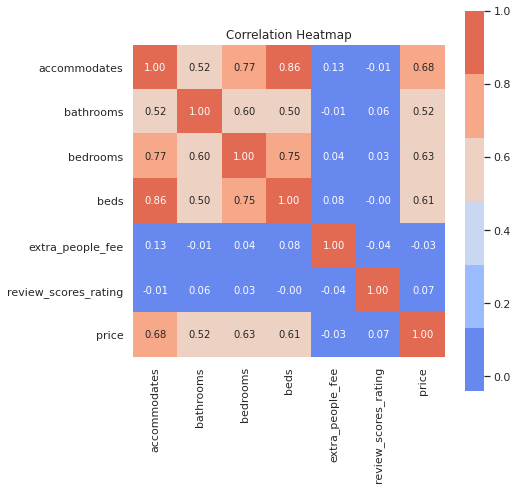

In [26]:
# Select numerical columns for correlation analysis
cols = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 
'extra_people_fee', 'review_scores_rating', 'price']

# Calculate correlation matrix
corrs = df[cols].corr()

# Set color palette for the heatmap
cmap = sns.color_palette("coolwarm")

# Plot the correlation heatmap
plt.figure(figsize=(7, 7))
sns.heatmap(corrs, cbar=True, annot=True, square=True, fmt='.2f',
            yticklabels=cols, xticklabels=cols, cmap=cmap)
plt.title('Correlation Heatmap')

# Save the plot as an image
plt.savefig('correlations.png')

# Display the plot
plt.show()


After analyzing the correlations heatmap diagram, we observe that the price of the listings exhibits correlations with several key features, namely the number of accommodates, bathrooms, bedrooms, and beds. It is worth noting that these features also show correlations among themselves.

The positive correlations between price and the number of accommodates, bathrooms, bedrooms, and beds are not surprising. It is intuitive to expect that larger and more spacious accommodations generally command higher prices. The number of accommodates reflects the capacity of the listing to accommodate guests, while the number of bathrooms, bedrooms, and beds indicates the size and amenities provided, which can contribute to the pricing structure.

Additionally, the observed correlations between these features themselves indicate their interdependence. For instance, the number of bedrooms is likely to be associated with the number of beds, and the number of bathrooms could be related to the number of bedrooms.

Overall, these findings validate the expectation that the price of a listing is influenced by the size and capacity of the accommodation. The correlations between price and these specific features provide valuable insights for understanding the factors that impact the pricing of listings in the dataset.

## Conclusion

Throughout this analysis, our objective was to gain insights into the factors influencing reservation prices using the AirBnB dataset for Seattle. While it is important to acknowledge that results may differ for other cities, the methodology employed here can be applied to analyze data from various locations.

The key findings from the Seattle data analysis are as follows:
- The fundamental characteristics of a listing, such as the number of bedrooms, bathrooms, beds, and accommodates, have a discernible impact on reservation prices. Larger and more spacious accommodations tend to command higher prices.
- The time of year also plays a significant role in determining reservation prices. Specifically, the summer season emerges as the busiest time to visit Seattle, with increased demand potentially resulting in higher prices.

Armed with this knowledge, individuals can make informed decisions when selecting among the various offerings on AirBnB, ultimately optimizing their choice of accommodation and potentially saving money.

With the analysis providing valuable insights, it is now time for travelers to put these findings into practice and embark on their journeys, equipped with the ability to make well-informed decisions regarding their accommodations.